User Based Recommender - Lectures Week 4
======

# User filtered algorithms

* our past tests predict our future
	* we have stable taste
	* our system is scoped within system of agreement - we agree on one thing then we agree on others
* measure of inter-user agreement
	* correlation, vector cosine
* personalised recommendations
	* weighted combinations of other ratings
* we need tweaks to make stuff works
* computation will be an issue
	* correlation of all users O(n)
	* pairwise correlations is O(m^2n)
	* recommendations > O(mn)
	* solutions 
		* persistent neighbourhood (m -> k)
		* cached or incremental correlations

# Basic user breakdown

* prediction for user a using rating r and accounting for diference between users with weight w $p_{a,i} = \frac{\sum_{u=1} ^n r_{u,i} w_{u,i}}{\sum_{u=1} ^n w_{u,i} }$
* another approach is to estimate relative likeness from each user and from there estimate it for each user
	* $p_{a,i} = \frac{\sum_{u=1} ^n (r_{u,i} -\overline{r_u})}{n}$
	* $p_{a,i} = \overline{r_a} + \frac{\sum_{u=1} ^n (r_{u,i} -\overline{r_u})w_{u,i} }{\sum_{u=1} ^n w_{u,i} }$
	* such normalisation has been measured to account for 50% of total accuracy in presonal collaborative filtering
* the best way to calculate weight is to calculate Pearson correlation coefficient
$\frac{cov(X,Y)}{\sigma_X \sigma_Y} = \frac{\sum_{u=1} ^n [(X-\mu X)(Y-\mu X)]}{\sigma_X  \sigma_Y}$
	* problems are when m is mall
	* it will not work with unary data
	* it work best with extremities (we both like/hate this)



# Assignment 3: User-User Collaborative Filtering

Excel file provided has the same table twice, transposed. I will only use movie-row here.

## Read File

In [1]:
import pandas as pd
import pylab
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import copy

#import pdb #debuggera
%matplotlib inline

from __future__ import division #so I can have float as std and int as //

In [15]:
dataFile = "Assignment3.csv"
print("reading %s" % dataFile)
dfData = pd.read_csv(dataFile, delimiter = ",", error_bad_lines=True, encoding = 'utf-8-sig',na_values = ["NULL",""],header =0);
dfData.head()

reading Assignment3.csv


,MovieID,1648,5136,918,2824,3867,860,3712,2968,3525,...,3556,5261,2492,5062,2486,4942,2267,4809,3853,2288
0,11: Star Wars: Episode IV - A New Hope (1977),NaN,4.5,5.0,4.5,4.0,4.0,NaN,5.0,4.0,...,4,NaN,4.5,4.0,3.5,NaN,NaN,NaN,NaN,NaN
1,12: Finding Nemo (2003),NaN,5.0,5.0,NaN,4.0,4.0,4.5,4.5,4.0,...,4,NaN,3.5,4.0,2.0,3.5,NaN,NaN,NaN,3.5
2,13: Forrest Gump (1994),NaN,5.0,4.5,5.0,4.5,4.5,NaN,5.0,4.5,...,4,5.0,3.5,4.5,4.5,4.0,3.5,4.5,3.5,3.5
3,14: American Beauty (1999),NaN,4.0,NaN,NaN,NaN,NaN,4.5,2.0,3.5,...,4,NaN,3.5,4.5,3.5,4.0,NaN,3.5,NaN,NaN
4,22: Pirates of the Caribbean: The Curse of the...,4,5.0,3.0,4.5,4.0,2.5,NaN,5.0,3.0,...,3,1.5,4.0,4.0,2.5,3.5,NaN,5.0,NaN,3.5


# Part 1 - Without Normalization

Implement user-user collaborative filtering without normalization.

* Complete the user-by-user correlations matrix
* Identify the top 5 neighbors (the users with the 5 largest, positive correlations) for users 3867 and 89

In [31]:
#find top 5 correlations for the specific user
def GetTopFive(user):
    user.sort(ascending=False)
    top5 = user.head(6) #get top6
    top5 = top5.tail(-1) #remove 1st - autocorr with itself
    return top5

In [36]:
#nice corelation plot based on internet code
def MakeNiceCorrPlot(pandaDF):
	corr = pandaDF.corr()

	# Generate a mask for the upper triangle
	mask = np.zeros_like(corr, dtype=np.bool)
	mask[np.triu_indices_from(mask)] = True

	# Set up the matplotlib figure
	f, ax = plt.subplots(figsize=(11, 9))

	# Draw the heatmap with the mask and correct aspect ratio
	sns.heatmap(corr, mask=mask, cmap="gist_rainbow", vmax=.3,square=True,linewidths=.5, cbar_kws={"shrink": .5}, ax=ax); 
	# xticklabels=5, yticklabels=5,  


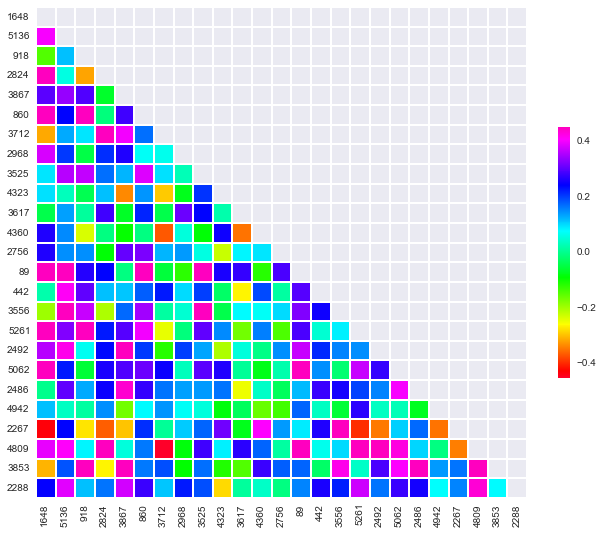

In [37]:
corrMatrix = dfData.corr()
MakeNiceCorrPlot(dfData)
#corrMatrix.columns
user1= corrMatrix.ix['3867',:]
user2= corrMatrix.ix['89',:]

user1 = GetTopFive(user1)
user2 = GetTopFive(user2)

* compute the predictions for each movie for users 3867 and 89 by taking the correlation-weighted average of the ratings of the top-five neighbors

In [76]:
def userProfile(preferecesData,userVotes):
  cols = [pd.DataFrame(preferecesData[col].values * userVotes.values, columns=[col]) for col in preferecesData]
  votes = cols[0].join(cols[1:])
  votes = votes.sum()

  return votes